**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
#from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance as dist
from scipy.stats import mode

from sklearn.feature_extraction.text import CountVectorizer

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', dist_meth='pure_numpy'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.dist_meth = dist_meth
    
    def fit(self, X, y):
        if self.n_neighbors < X.shape[0]:
            self.X_train = X
            #print(self.X_train)
            self.y_train = np.array(y)
            self.classes = np.unique(y)

        else:
            print("Parameter n_neingbors is higher than \
                   the number of observations")
            return
    
    def predict(self, X, dist_meth=None):
        n_neighbors = self.n_neighbors
        algorithm = self.algorithm
        if dist_meth is None:
            dist_meth = self.dist_meth
        #normal people don't use params in predict, but now it's convinient

        if algorithm == 'brute':
            if (dist_meth=='pure_numpy' or dist_meth=='pairwise_euclid' or dist_meth=='cosin'):
                neigh_ind, neigh_dist = self.kneighbors_brute(X, dist_meth)
            else:
                print("Use 'pairwise_euclid', 'cosin' or 'pure_numpy' (default) for distances")
        elif algorithm == 'kd_tree':
            tree = KDTree(self.X_train, leaf_size=2)
            neigh_dist, neigh_ind = tree.query(X, k=n_neighbors)
        else:
            print("The name of algorithm is incorrect. \
                   Use 'brute' or 'kd_tree' ")
        y_pred = np.transpose(mode(self.y_train[neigh_ind], axis=1)[0])[0]
        return y_pred
            
    def kneighbors_brute(self, X, dist_meth):

        n_neighbors = self.n_neighbors
        if X.ndim==1:
            X=X[np.newaxis,:]
        #print(X.shape, self.X_train.shape)
        if dist_meth=='pure_numpy':
            distances = np.apply_along_axis(lambda x: np.linalg.norm(x-X,axis=1), 1, self.X_train).T
        elif dist_meth=='cosin':
            distances = -cosine_similarity(X, self.X_train)
        else:
            distances = euclidean_distances(X, self.X_train)
        # It seems mincowski from scipy.spatial work slowly. Proved by experience and discussion:
        # https://stackoverflow.com/questions/20277982/fastest-pairwise-distance-metric-in-python
        
        sort_indices = distances.argsort(axis=1)[:, :n_neighbors]
        #it is possible make O(k log n + n) by heapq (not n log n), 
        #but with euclidian_distances and numpy Classifier works fast enough
        
        distances.sort()
        distances[:, :n_neighbors]

        return sort_indices, distances[:, :n_neighbors]
    
    def score(self, X, y):

        y_pred = self.predict(X)

        differing_labels = np.count_nonzero(y_pred - y)

        return 1 - differing_labels / y_pred.shape[0]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [8]:
accuracy_score(y_test, my_clf_pred)

0.9333333333333333

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [21]:
%time clf.fit(X_train, y_train)

Wall time: 995 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [22]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [23]:
%time clf.predict(X_test)

Wall time: 2 ms


array([0, 2, 1, 2, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0])

In [24]:
%time my_clf.predict(X_test)

Wall time: 2.99 ms


array([0, 2, 1, 2, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0])

In [25]:
%time my_clf.predict(X_test, dist_meth = 'pairwise_euclid')

Wall time: 2 ms


array([0, 2, 1, 2, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0])

In [26]:
%time my_clf.predict(X_test, dist_meth = 'cosin')

Wall time: 1.96 ms


array([0, 2, 2, 2, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [27]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135, 4), (15, 4), (135,), (15,))

In [29]:
%time clf.fit(X_train, y_train)

Wall time: 4.99 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [30]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [31]:
%time clf.predict(X_test)

Wall time: 5.99 ms


array([0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0])

In [32]:
%time my_clf.predict(X_test)

Wall time: 996 µs


array([0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0])

In [33]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [34]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [35]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

По частотности ограничим потом, сначала вырежем то, что не является словами.
Кроме того, уберём общеупотребительные слова, которые вряд ли влияют на модель.

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
from nltk.corpus import stopwords
stopwords.words('english')
print(stopwords.words()[620:630])

['your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's"]


In [38]:
vectorizer = CountVectorizer(strip_accents='ascii', analyzer='word', stop_words=stopwords.words('english'), 
                             token_pattern=r'\b[^\d\W_]+\b')
X = vectorizer.fit_transform(data)

In [39]:
vectorizer.get_feature_names()[100:110]

['abernathy',
 'aberrant',
 'aberration',
 'aberrations',
 'abetting',
 'abfb',
 'abfdefghiijklmmnohpp',
 'abgarovich',
 'abhin',
 'abhor']

In [40]:
X.shape, target.shape

((11314, 67610), (11314,))

Без предобработки мы бы насчитали не 67, а более 110 тысяч слов.

Обрежу по частотам довольно сильно, чтобы получить хоть какой-нибудь результат за разумное количество времени.

In [41]:
cond1 = np.ravel(X.sum(axis=0) > 50)
cond2 = np.ravel(X.sum(axis=0) < 55)
#np.count_nonzero(cond)
#print(cond)
X_new=X[:,cond1 & cond2]
X_new.shape, target.shape

((11314, 213), (11314,))

In [42]:
X_new=X_new.toarray()

In [43]:
import sklearn.model_selection as MS
#cross_validate, KFold, cross_val_score

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [44]:
my_clf=MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
%time MS.cross_val_score(my_clf, X_new, target, scoring = 'accuracy', cv=3, n_jobs=-1)

Wall time: 2min 43s


array([0.10577943, 0.11217184, 0.11482365])

In [45]:
my_clf=MyKNeighborsClassifier(n_neighbors=2, algorithm='brute', dist_meth='pairwise_euclid')
%time MS.cross_val_score(my_clf, X_new, target, scoring = 'accuracy', cv=3, n_jobs=-1)

Wall time: 3.45 s


array([0.10577943, 0.11217184, 0.11482365])

Несмотря на то, что первый метод хорошо справился с первыми данными (про ирисы) -- здесь он работает медленно (но также).
Будем экономить время и использовать второй способ.

Теперь обрежем по частотам приемлимым способом.

In [46]:
cond1 = np.ravel(X.sum(axis=0) > 10)
cond2 = np.ravel(X.sum(axis=0) < 1000)
#np.count_nonzero(cond)
#print(cond)
X_new=X[:,cond1 & cond2]
X_new.shape, target.shape

((11314, 11355), (11314,))

In [47]:
X_new=X_new.toarray()

In [48]:
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute', dist_meth='pairwise_euclid')
my_clf.fit(X_new, target)
my_clf.X_train.shape, my_clf.y_train.shape

((11314, 11355), (11314,))

In [49]:
scores = MS.cross_validate(my_clf, X_new, target, cv=3, n_jobs=-1)
np.mean(scores['test_score'])

0.24032112757224558

Учитывая, что мы выбираем из 20 категорий -- для евклидовой метрики не так уж плохо. Как мы увидим далее, для анализа текстов лучше подходит косинусная метрика. 

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [50]:
score_store=[]
for i in range(1,11):
    my_clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='brute', dist_meth='pairwise_euclid')
    my_clf.fit(X_new, target)
    scores = MS.cross_validate(my_clf, X_new, target, cv=3, n_jobs=-1)
    score_store.append(np.mean(scores['test_score']))
print(score_store)

[0.28575059201873537, 0.24032112757224558, 0.2379343989904912, 0.23722762287288743, 0.23599022567998848, 0.2355480687905008, 0.23236586556312108, 0.230068163588488, 0.228124037146428, 0.22750558460930323]


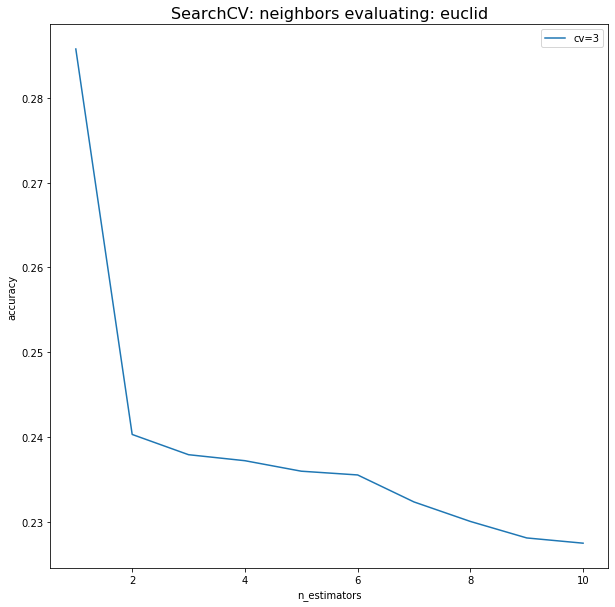

In [51]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.title("SearchCV: neighbors evaluating: euclid",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
a=plt.gca()
a.plot(range(1,11), score_store, label='cv=3')
plt.legend()
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [52]:
score_store=[]
for i in range(1,11):
    my_clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='brute', dist_meth='cosin')
    my_clf.fit(X_new, target)
    scores = MS.cross_validate(my_clf, X_new, target, cv=3, n_jobs=-1)
    score_store.append(np.mean(scores['test_score']))
print(score_store)

[0.5360614469656855, 0.4946078559571525, 0.5182959637178262, 0.5396853149639034, 0.5574509388170911, 0.563196095971198, 0.5692949458289851, 0.5762769611888987, 0.5809614620479504, 0.5819338181967479]


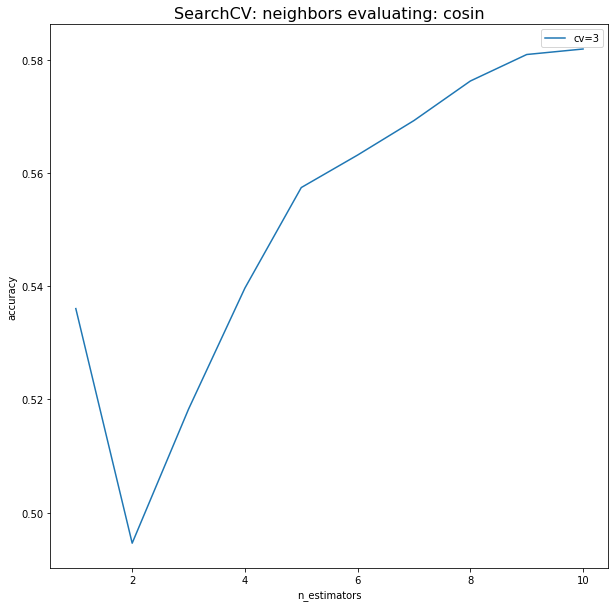

In [53]:
plt.figure(figsize=(10, 10))
plt.title("SearchCV: neighbors evaluating: cosin",
          fontsize=16)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
a=plt.gca()
a.plot(range(1,11), score_store, label='cv=3')
plt.legend()
plt.show()

Косинусная метрика работает значительно лучше!
Выбираем её для случая десяти соседей.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [54]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [55]:
y_data = newsgroups_test['data']
y_target = newsgroups_test['target']
test_len=len(y_data)
test_len

7532

In [56]:
all_data = []
all_data.extend(data)
all_data.extend(y_data)
len(all_data)

18846

In [57]:
vectorizer = CountVectorizer(strip_accents='ascii', analyzer='word', stop_words=stopwords.words('english'), 
                             token_pattern=r'\b[^\d\W_]+\b')
all_X = vectorizer.fit_transform(all_data)

In [58]:
vectorizer.get_feature_names()[100:110]

['abcs',
 'abd',
 'abdel',
 'abdelhamoud',
 'abdi',
 'abdicate',
 'abdication',
 'abdn',
 'abdo',
 'abdomen']

In [59]:
all_X.shape, y_target.shape

((18846, 86763), (7532,))

In [60]:
cond1 = np.ravel(all_X.sum(axis=0) > 10)
cond2 = np.ravel(all_X.sum(axis=0) < 1000)
#np.count_nonzero(cond)
#print(cond)
all_X_new=all_X[:,cond1 & cond2]
all_X_new.shape, target.shape, y_target.shape

((18846, 15133), (11314,), (7532,))

In [61]:
all_X_new=all_X_new.toarray()

In [62]:
train_len=target.shape[0]
print(train_len)
all_X_new[:-test_len,:].shape, all_X_new[train_len:,:].shape

11314


((11314, 15133), (7532, 15133))

In [63]:
score_store=[]

my_clf = MyKNeighborsClassifier(n_neighbors=10, algorithm='brute', dist_meth='cosin')
my_clf.fit(all_X_new[:-test_len,:], target)
my_predict=my_clf.predict(all_X_new[train_len:,:])


In [64]:
differing_labels = np.count_nonzero(my_predict - y_target)
accuracy=1 - differing_labels / my_predict.shape[0]
accuracy

0.5278810408921932

По сравнению с тестовой выборкой показатель упал более, чем на 0.05.

Тем не менее, мы неплохо разбрасываем новости по темам.
Нельзя сказать, что получилось принципиально хуже -- весь смысл скользящего контроля (перекрёстной проверки) как раз и состоит в том, что на новой выборке алгоритм будет работать примерно также. 

**Черновик**

In [65]:
a=np.array([[21,0,0],[1,2,3],[4,5,6]])
b=np.array([[5,5,5],[10,10,10]])
c=np.apply_along_axis(lambda x: a-x, 1, b)

In [66]:
c, c.shape

(array([[[ 16,  -5,  -5],
         [ -4,  -3,  -2],
         [ -1,   0,   1]],
 
        [[ 11, -10, -10],
         [ -9,  -8,  -7],
         [ -6,  -5,  -4]]]), (2, 3, 3))

In [67]:
np.linalg.norm(np.apply_along_axis(lambda x: x-b, 1, a), axis=2) #memory unfriendly variant

array([[17.49285568, 17.91647287],
       [ 5.38516481, 13.92838828],
       [ 1.41421356,  8.77496439]])

In [68]:
np.apply_along_axis(lambda x: np.linalg.norm(x-b,axis=1), 1, a)

array([[17.49285568, 17.91647287],
       [ 5.38516481, 13.92838828],
       [ 1.41421356,  8.77496439]])

In [69]:
euclidean_distances(a,b)

array([[17.49285568, 17.91647287],
       [ 5.38516481, 13.92838828],
       [ 1.41421356,  8.77496439]])